Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [0]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [295]:
import pandas as pd
import numpy as np
from scipy.stats import mode

from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [166]:
# Check Pandas Profiling version
import pandas_profiling
pandas_profiling.__version__

'2.4.0'

In [167]:
# Seeing the head of the train dataFrame
train.head(1)

id  amount_tsh  ... waterpoint_type_group status_group
0  69572      6000.0  ...    communal standpipe   functional

[1 rows x 41 columns]

In [0]:
# Will be doing a split of the train dataFrame into a train and val set
train ,val = train_test_split(train, train_size=.80, test_size=.2, 
                             random_state=42, 
                             stratify=train['status_group'])

In [219]:
# Looking at the size of the train and the validate and the test
print(train.shape, val.shape, test.shape)

(47520, 41) (11880, 41) (14358, 40)


In [170]:
# Old code for Pandas Profiling version 2.3
# It can be very slow with medium & large datasets.
# These parameters will make it faster.

# profile = train.profile_report(
#     check_correlation_pearson=False,
#     correlations={
#         'pearson': False,
#         'spearman': False,
#         'kendall': False,
#         'phi_k': False,
#         'cramers': False,
#         'recoded': False,
#     },
#     plot={'histogram': {'bayesian_blocks_bins': False}},
# )
#

# New code for Pandas Profiling version 2.4
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True)

profile.to_notebook_iframe()

In [0]:
# saving the profile report to an htmlfile
profile.to_file(output_file='tanzania_profile_report_minimal.html')

In [172]:
# Finding the base line for the training data
train['status_group'].value_counts(normalize=True)

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

In [0]:
# the baseline for the most common category is about 54%

In [174]:
train.head(1).T

43360
id                                       72938
amount_tsh                                   0
date_recorded                       2011-07-27
funder                                     NaN
gps_height                                   0
installer                                  NaN
longitude                              33.5429
latitude                              -9.17478
wpt_name                          Kwa Mzee Noa
num_private                                  0
basin                               Lake Nyasa
subvillage                         Mpandapanda
region                                   Mbeya
region_code                                 12
district_code                                4
lga                                     Rungwe
ward                                    Kiwira
population                                   0
public_meeting                            True
recorded_by            GeoData Consultants Ltd
scheme_management                          VWC
scheme_name                                  K
permit                                     NaN
construction_year                            0
extraction_type                        gravity
extraction_type_group                  gravity
extraction_type_class                  gravity
management                                 vwc
management_group                    user-group
payment                              never pay
payment_type                         never pay
water_quality                             soft
quality_group                             good
quantity                          insufficient
quantity_group                    insufficient
source                                  spring
source_type                             spring
source_class                       groundwater
waterpoint_type             communal standpipe
waterpoint_type_group       communal standpipe
status_group                        functional

In [0]:
# taking off the target from the train dataSet
target = 'status_group'
# Getting the amounts in each feature of the cardinal features
cardinalFeatureAmounts = train.select_dtypes(exclude='number')
cardinalFeatureAmounts = cardinalFeatureAmounts.nunique()

# Creating a list of the features that have less than 50 cardinality
cardinal = cardinalFeatureAmounts[cardinalFeatureAmounts <= 50].index.tolist()

In [0]:
# doing some imports for plotly express
import plotly.express as px

In [177]:
# Want to look at the longitude and the latitute compared to the status_group
fig = px.scatter_mapbox(train, lat='latitude', lon="longitude", color='status_group')
fig.update_layout(mapbox_style='stamen-terrain')
fig.show()

In [178]:
# Doing a scatter plot of gps_height and status_group
px.scatter(train, x='gps_height', y='status_group')

In [179]:
nonFunc = train[train['status_group'] == 'non functional']
px.histogram(nonFunc, x='basin', y='status_group',)

In [180]:
# Looking at the extraction type compared to if it is functional
extType = train[train['status_group'] == 'functional' ]
nonfunc = train[train['status_group'] == 'non functional' ]
px.histogram(extType, x='extraction_type', y='status_group')

In [181]:
# Seeing if a extraction type is more commonly broken than other types
px.histogram(nonfunc, x='extraction_type', y='status_group')

In [182]:
# Checking to see the number of region code and 
#the number of wards in the dataSet
print(train['ward'].nunique())
print(train['region_code'].nunique())
train['subvillage'].isna().sum()
train['region_code'].isna().sum()

2082
27


0

In [183]:
train[['latitude']].describe()

latitude
count  4.752000e+04
mean  -5.705946e+00
std    2.941332e+00
min   -1.164944e+01
25%   -8.528215e+00
50%   -5.021436e+00
75%   -3.327185e+00
max   -2.000000e-08

In [184]:
# Looking at the values that have near zero in the dataSet
t = train[train['latitude'] == -2.000000e-08]
t


id  amount_tsh  ... waterpoint_type_group             status_group
32604   3286         0.0  ...             hand pump               functional
37113  10809         0.0  ...             hand pump  functional needs repair
24948  39399         0.0  ...             hand pump               functional
33079   9314         0.0  ...             hand pump               functional
43390  10432         0.0  ...             hand pump               functional
...      ...         ...  ...                   ...                      ...
12118  69295         0.0  ...             hand pump  functional needs repair
13360  23106         0.0  ...             hand pump  functional needs repair
29994  36396         0.0  ...             hand pump               functional
33658  12635         0.0  ...    communal standpipe  functional needs repair
11992  12601         0.0  ...             hand pump               functional

[1442 rows x 41 columns]

In [185]:
trainCard = train.select_dtypes(exclude='number').columns.to_list()
trainCard

['date_recorded',
 'funder',
 'installer',
 'wpt_name',
 'basin',
 'subvillage',
 'region',
 'lga',
 'ward',
 'public_meeting',
 'recorded_by',
 'scheme_management',
 'scheme_name',
 'permit',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group',
 'status_group']

In [221]:
tr = train[train['ward'] == 'Igosi']
tr.isnull().sum()

id                       0
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
subvillage               0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
recorded_by              0
scheme_management        2
scheme_name              6
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
s

In [0]:
Wards = train['ward'].value_counts(dropna=False).index.to_list()
theList = []
for tWard in Wards:
  frame = df[df['ward'] == tWard]
  a = mode(frame['latitude'])
  
  theList.append(a)
    

In [301]:
train['public_meeting'].value_counts(normalize=True, dropna=False)

True     0.859386
False    0.084975
NaN      0.055640
Name: public_meeting, dtype: float64

In [240]:
print(theList[0][0][0])

-9.40726816


In [226]:
print(theList)

['Igosi', 'Imalinyi', 'Siha Kati', 'Mdandu', 'Nduruma', 'Mishamo', 'Chalinze', 'Msindo', 'Maji ya Chai', 'Kitunda', 'Usuka', 'Chanika', 'Vikindu', 'Ngarenanyuki', 'Maramba', 'Matola', 'Mtwango', 'Itete', "Wanging'ombe", 'Kikatiti', 'Ifakara', 'Zinga/Ikerege', 'Olkokola', 'Magomeni', 'Simbo', 'Maposeni', 'Mvomero', 'Igongolo', 'Mlangali', 'Mahongole', 'Mamire', 'Rujewa', 'Nkungulu', 'Kiranyi', 'Nkoma', 'Siha Mashariki', 'Lupalilo', 'Mahembe', 'Kagongo', 'Masama Magharibi', 'Ihanda', 'Kidatu', 'Hedaru', 'Bugarama', 'Yombo', 'Makwale', 'Isongole', 'Kanga', 'Chinamili', 'Tinde', 'Masama Mashariki', 'Makuyuni', 'Kakonko', 'Mabwerebwere', 'Diongoya', 'Lembeni', 'Mkongo', 'Kimochi', 'Ruhembe', 'Kirua Vunjo Kusini', 'Kibaoni', 'Soga', 'Leguruki', "Mang'ula", 'Ruanda', 'Malindi', 'Mhunze', 'Ipande', 'Mbulumbulu', 'Kisesa', 'Kenyamonta', 'Wino', 'Mlali', 'Kifanya', 'Mkula', 'Lumemo', 'Matendo', "Ilkiding'a", 'Ilolangulu', 'Bungu', 'Manyoni', 'Ilima', 'Mlangarini', 'Chimala', 'Keni Mengeni', 'Lup

In [0]:

# Creating the list of the columns that I want to drop here and
# then will pass them into the wrangle function
target = 'status_group'
# This is a list of some of the colums that I want to drop
# Will drop subvillage -- because similar results as lat and lon
# Dropping funder:  has high cardinality
# Dropping the wpt_name:  has high cardinality is the name of the water point
# Dropping payment_type:  same as payment(duplicate)
cols_to_drop = ['id', 'quantity_group', 'recorded_by', "subvillage", 
                'num_private', 'funder', 'wpt_name' ,'scheme_name', 'payment_type',
                'quality_group', ]


In [0]:
# These are some inner functions in my wrangle function that help
# With the fixing the latitude and the longitude
def myLatitude(theRow):
  
  if pd.isnull(theRow['latitude']):
    theWard = theRow['ward']
    lat = df[df['ward'] == theWard]
    theMode = mode(lat['latitude'])
    return (theMode[0][0])
  return (theRow['latitude'])

def myLon(theRow): 
  if (pd.isnull(theRow['longitude'])):
    lon = df[df['ward'] == theRow['ward']]
    theMode = mode(lon['longitude'])
    return (theMode[0][0])
  return (theRow['longitude'])

In [0]:
!pip install ipdb

In [0]:
import ipdb

In [0]:
# This is my wrangle function

def wrangleFxn(df, numCardinal=50, useMode=True, num=None, highVar=None, lowVar=None):
  ''' This is the wrangle function
      It will take in a dataFrame either the train, test, or validate.
      It should have the TARGET already removed from it. 

      It will drop the columns before looking at the cardinality of the
      columns.

      numCardinal:  default is 50. This is the threshold.  If it is less
                    than  or equal to this number it is retained in the 
                    features.
      useMode:  default is True.  This will use the apply functiontion to 
                make the lat and lon have values similar to those in 
                the ward that it is found.
      num:      default is None.  It this is set to a number, 
                it will further reduce the cardinality of the
                cardinal features to a specified number. 
      
      highVar:  Default is None. If set will drop any columns that have more 
                variance than what is set here as the threshold.  Should be
                set as a float ie(.90 or .8)
      
      lowVar:   Default is None. if set will drop any columns who have less
                variance than here.  Should be set as a float ie(.1 or .234)

      returns:  Will return the datframe prepared for the pipeline.

  '''
  
  
  target = 'status_group'
  # making the copy
  df = df.copy()
  # will try to drop the target if it is present
  if target in df.columns:
    df = df.drop(columns=[target])
  
  # Will be setting the long and lat before doing any dropping
  df['latitude'] = df['latitude'].replace(-2e-08, 0)

  # Getting rid of the zeros in the latitude and the longitude putting in 
  # np.nan
  cols_w_zeros = ['latitude', 'longitude']

  for col in cols_w_zeros:
    df[col] = df[col].replace(0, np.nan)

  if useMode == True:
    #This is to make the latitude and the longitude have
    # numbers similar to those whose region they are in
    df['latitude'] = df.apply(myLatitude, axis=1)
    df['longitude'] = df.apply(myLon, axis=1)
    pd.to_numeric(df['latitude'])
  
 
  # Dropping the columns preset to drop
  df = df.drop(columns= cols_to_drop)

  # Getting a list of the cardinal features at the start
  cardinals = df.select_dtypes(exclude='number')

  # This to drop features that are left that have high skew (almost no variance)
  # or possibly too much variance
  if highVar != None:
    # Getting a list of the cardinal features at the start
    cardinals = df.select_dtypes(exclude='number')
    tCol = cardinals.columns.to_list()
    for col in tCol:
      if df[col].value_counts(normalize=True, dropna=False).to_list()[0]  > highVar:
        df = df.drop(columns=[col])
  
  if lowVar != None:
    # Getting a list of the cardinal features at the start
    cardinals = df.select_dtypes(exclude='number')
    tCol = cardinals.columns.to_list()
    
    for col in tCol:
      if df[col].value_counts(normalize=True, dropna=False).to_list()[0] < lowVar:
        df = df.drop(columns=[col])


  # Getting the number of features that are numerical
  numerical_features = df.select_dtypes(include='number').columns.tolist()

  # Getting the amounts in each feature of the cardinal features
  cardinalFeatureAmounts = df.select_dtypes(exclude='number')
  cardinalFeatureAmounts = cardinalFeatureAmounts.nunique()
  # checking to see if 'ward' is in the list

  # Creating a list of the features that have less than 50 cardinality
  cardinal = cardinalFeatureAmounts[cardinalFeatureAmounts <= numCardinal].index.tolist()
  
  if num != None:
    #This is to reduce the number of features in the cardinal groups
    for feature in cardinal:
      # getting the top specified amount
      topNum = df[feature].value_counts().index[:num-1].tolist()
      # replace those that are not in there with 'other'
      df.loc[~df[feature].isin(topNum), feature] = 'Other'

  # List of all the features
  features = numerical_features + cardinal

  
  

  return df[features]

In [0]:
# Trying the wrangle function
x_train = wrangleFxn(train, num=10, highVar=.85, lowVar=.06)
x_val = wrangleFxn(val, num=10, highVar=.85, lowVar=.06)
x_test = wrangleFxn(test, num=10, highVar=.85, lowVar=.06)

In [304]:
print(x_train.shape, x_val.shape, x_test.shape)

(47520, 23) (11880, 23) (14358, 23)


In [305]:
x_train.columns.to_list()

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'region_code',
 'district_code',
 'population',
 'construction_year',
 'basin',
 'region',
 'scheme_management',
 'permit',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'payment',
 'quantity',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group']

In [0]:
# Creating the pipline for the model
# Doing some imports first
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier


In [0]:
y_train = train[target]
y_val = val[target]


In [313]:
# Instantiating
pipeline = make_pipeline( ce.OneHotEncoder(use_cat_names=True),
                         SimpleImputer(strategy="median"),
                         StandardScaler(),
                         DecisionTreeClassifier(criterion='gini', max_depth=19, random_state=42, min_samples_leaf=8))

pipeline.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'scheme_management',
                                     'permit', 'extraction_type',
                                     'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'payment', 'quantity', 'source',
                                     'source_type', 'source_class',
                                     'waterpoint_type',
                                     'waterpoint_type_group'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown...
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=19,
               

In [314]:
print(f'Accuracy for the train is: {pipeline.score(x_train, y_train)}')
print(f"Accuracy for the val is: {pipeline.score(x_val, y_val)}")

Accuracy for the train is: 0.8316287878787879
Accuracy for the val is: 0.775


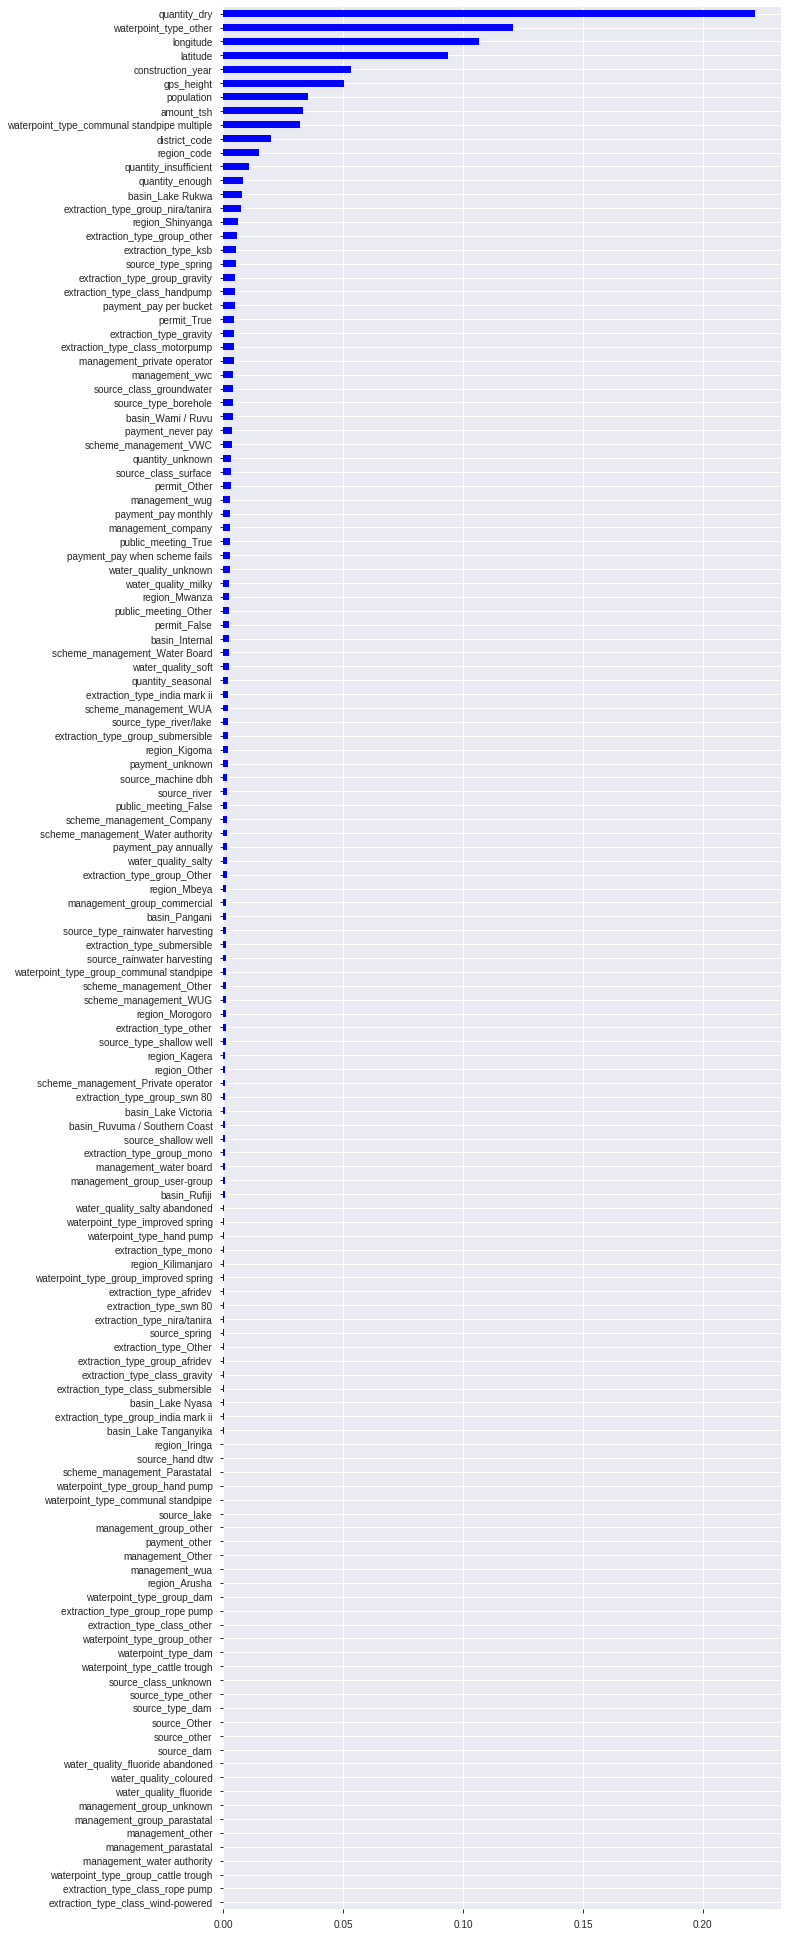

In [290]:
# doing the plotting
%matplotlib inline
import matplotlib.pyplot as plt

encoder = pipeline.named_steps['onehotencoder']
tree = pipeline.named_steps['decisiontreeclassifier']
encoded_columns = encoder.transform(x_train).columns
featureImp = tree.feature_importances_

s = pd.Series(featureImp, encoded_columns)
plt.figure(figsize=(10,35))
s.sort_values().plot.barh(color='blue')

In [0]:
# Submitting to kaggle
y_pred = pipeline.predict(x_test)

submissionCopy = sample_submission.copy()

submissionCopy['status_group'] = y_pred

submissionCopy.to_csv('submission2.csv', index=False)